# Detecting AI-Generated Content on HC3 Dataset
### This notebook is to perform linguistic and stylistic analysis of HC3

# Install Necessary Libraries

In [1]:
!pip install multiprocess

In [2]:
!pip install --upgrade datasets transformers

In [1]:
pip install --no-deps datasets==1.18.3

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset, load_metric
import pandas as pd
import torch

In [3]:
dataset = load_dataset("Hello-SimpleAI/HC3", "all")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Downloading:   0%|          | 0.00/9.47k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/73.7M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

Dataset new_dataset downloaded and prepared to /root/.cache/huggingface/datasets/Hello-SimpleAI___new_dataset/all/1.1.0/5af5910f9f3fe7aace30e32ad4c1ab776ca08183d00e9b2a091308549f69f683. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

# Dataset Overview

In [4]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'human_answers', 'chatgpt_answers', 'source'],
        num_rows: 24322
    })
})


In [5]:
# Convert the training split to a Pandas DataFrame
df = pd.DataFrame(dataset["train"])

# Overview of the dataset
print("Dataset Overview:")
print(df.head())

Dataset Overview:
  id                                           question  \
0  0  Why is every book I hear about a " NY Times # ...   
1  1  If salt is so bad for cars , why do we use it ...   
2  2  Why do we still have SD TV channels when HD lo...   
3  3  Why has nobody assassinated Kim Jong - un He i...   
4  4  How was airplane technology able to advance so...   

                                       human_answers  \
0  [Basically there are many categories of " Best...   
1  [salt is good for not dying in car crashes and...   
2  [The way it works is that old TV stations got ...   
3  [You ca n't just go around assassinating the l...   
4  [Wanting to kill the shit out of Germans drive...   

                                     chatgpt_answers       source  
0  [There are many different best seller lists th...  reddit_eli5  
1  [Salt is used on roads to help melt ice and sn...  reddit_eli5  
2  [There are a few reasons why we still have SD ...  reddit_eli5  
3  [It is generall

# Distribution of Sources

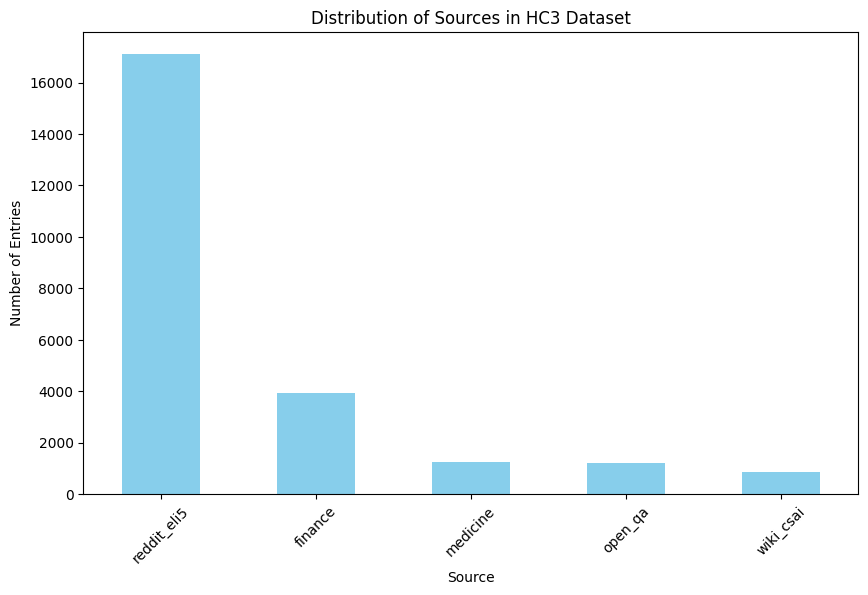

In [7]:
import matplotlib.pyplot as plt
from collections import Counter
import spacy
from transformers import pipeline

# 1. Distribution of Sources
source_counts = df["source"].value_counts()
plt.figure(figsize=(10, 6))
source_counts.plot(kind="bar", color="skyblue")
plt.title("Distribution of Sources in HC3 Dataset")
plt.xlabel("Source")
plt.ylabel("Number of Entries")
plt.xticks(rotation=45)
plt.show()

In [8]:
train_data = dataset["train"]

human_texts = [text for answers in train_data['human_answers'] for text in answers]
chatgpt_texts = [text for answers in train_data['chatgpt_answers'] for text in answers]

# Distribution of Average Answer Lengths

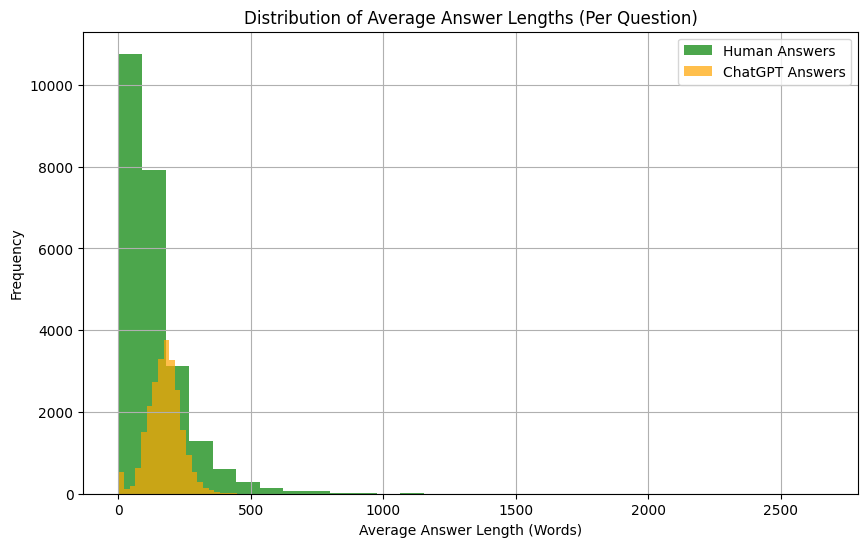

In [9]:
# Calculate average lengths per question for both human and ChatGPT answers
human_avg_lengths_per_question = [
    sum(len(a.split()) for a in answers) / len(answers) if answers else 0
    for answers in train_data["human_answers"]
]

chatgpt_avg_lengths_per_question = [
    sum(len(a.split()) for a in answers) / len(answers) if answers else 0
    for answers in train_data["chatgpt_answers"]
]

# Plot the histograms
plt.figure(figsize=(10, 6))
plt.hist(human_avg_lengths_per_question, bins=30, alpha=0.7, label="Human Answers", color="green")
plt.hist(chatgpt_avg_lengths_per_question, bins=30, alpha=0.7, label="ChatGPT Answers", color="orange")
plt.title("Distribution of Average Answer Lengths (Per Question)")
plt.xlabel("Average Answer Length (Words)")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()

# Vocabulary Density Distribution

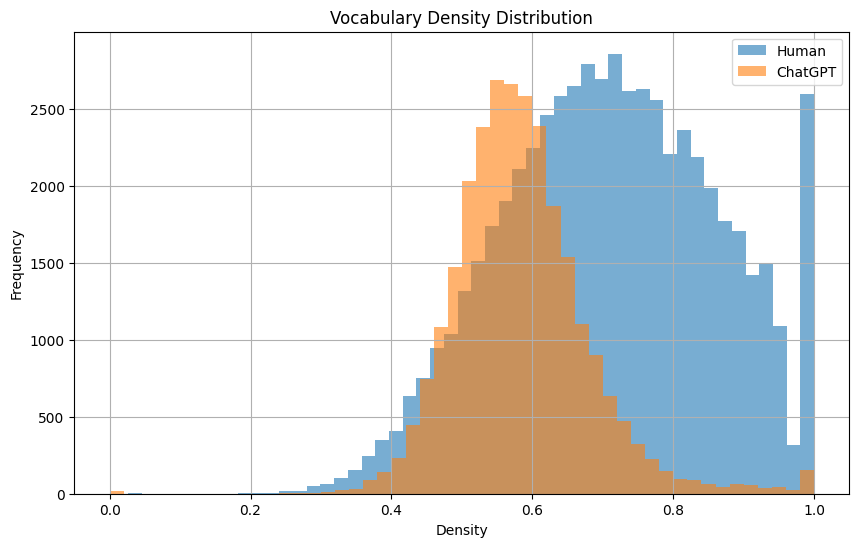

In [10]:
# Vocabulary Density Distribution
def calculate_vocab_density(texts):
    densities = []
    for text in texts:
        words = text.split()
        vocab = set(words)
        densities.append(len(vocab) / len(words) if len(words) > 0 else 0)
    return densities

human_vocab_density = calculate_vocab_density(human_texts)
chatgpt_vocab_density = calculate_vocab_density(chatgpt_texts)

# Plot
plt.figure(figsize=(10, 6))
plt.hist(human_vocab_density, bins=50, alpha=0.6, label='Human')
plt.hist(chatgpt_vocab_density, bins=50, alpha=0.6, label='ChatGPT')
plt.title("Vocabulary Density Distribution")
plt.xlabel("Density")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()

# POS Tagging Analysis

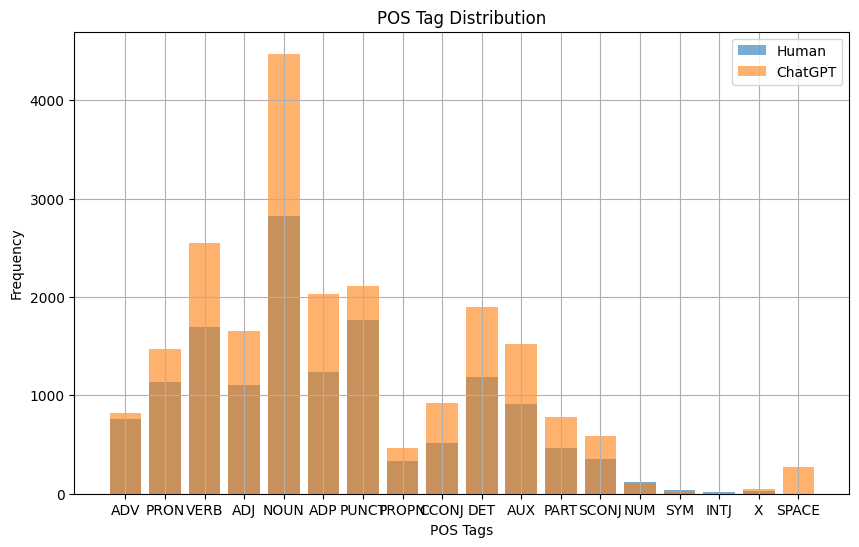

In [11]:
# === POS Tagging Analysis ===
nlp = spacy.load("en_core_web_sm")

def get_pos_distribution(texts):
    pos_counts = Counter()
    for text in texts[:100]: 
        doc = nlp(text)
        pos_counts.update([token.pos_ for token in doc])
    return pos_counts

human_pos = get_pos_distribution(human_texts)
chatgpt_pos = get_pos_distribution(chatgpt_texts)

# Plot POS distribution
plt.figure(figsize=(10, 6))
plt.bar(human_pos.keys(), human_pos.values(), alpha=0.6, label='Human')
plt.bar(chatgpt_pos.keys(), chatgpt_pos.values(), alpha=0.6, label='ChatGPT')
plt.title("POS Tag Distribution")
plt.xlabel("POS Tags")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()

# Sentiment Analysis

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


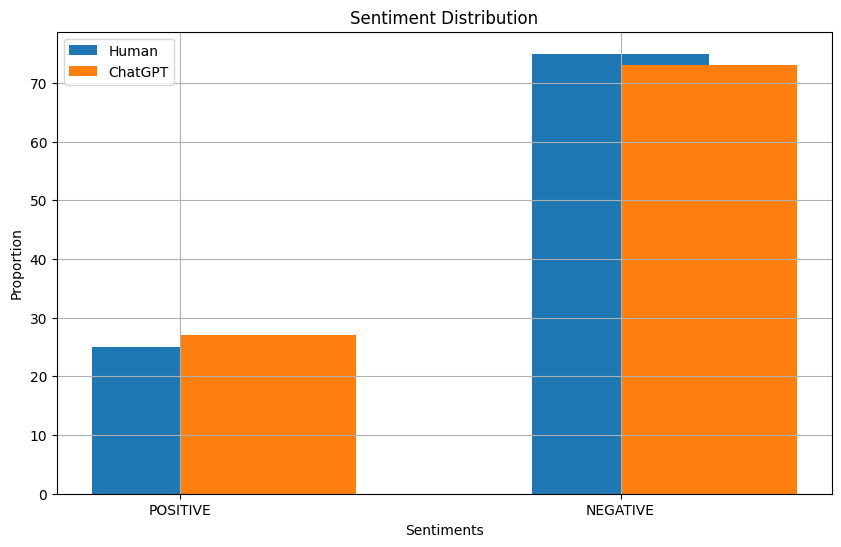

In [12]:
# === Sentiment Analysis ===
from transformers import pipeline

# Load the sentiment-analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis", truncation=True)

# Analyze sentiment with truncation
def analyze_sentiment(texts, max_length=512):
    # Ensure no text exceeds the model's max length
    truncated_texts = [text[:max_length] for text in texts]  # Truncate text to avoid overflow
    sentiments = [sentiment_analyzer(text)[0]['label'] for text in truncated_texts[:100]]  # Analyze part of the dataset
    return Counter(sentiments)

# Run sentiment analysis
human_sentiments = analyze_sentiment(human_texts)
chatgpt_sentiments = analyze_sentiment(chatgpt_texts)

# Plot the sentiment distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

labels = list(set(human_sentiments.keys()).union(set(chatgpt_sentiments.keys())))
human_values = [human_sentiments.get(label, 0) for label in labels]
chatgpt_values = [chatgpt_sentiments.get(label, 0) for label in labels]

x = range(len(labels))
plt.bar(x, human_values, width=0.4, label='Human', align='center')
plt.bar(x, chatgpt_values, width=0.4, label='ChatGPT', align='edge')

plt.title("Sentiment Distribution")
plt.xlabel("Sentiments")
plt.ylabel("Proportion")
plt.xticks(ticks=x, labels=labels)
plt.legend()
plt.grid()
plt.show()